## Learning Rate Schedulers with Skorch 

This notebook demonstrates 3 learning rate schedulers in skorch:

1) StepLR: Reduces learning rate by a factor at fixed steps
2) ReduceLROnPlateau: Adapts learning rate based on model performance
3) Cosine Annealing: Smoothly reduces learning rate using cosine function

This notebook uses the simulate method in 'LRScheduler' to visualize the difference between different schedulers.

Firstly you will need to install the following libraries: skorch,numpy,matplotlib and torch.

<a href="" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>


<a href="notebooks/Learning_Rate_Scheduler.ipynb" target="_blank"><img src="https://img.shields.io/github/view/yourusername/yourrepository/main/yourfile.ipynb" alt="View Source on GitHub"></a>


# Imports

In [47]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler

## Data Preparation

The dataset will be split into train and test datasets. We will scale the features upto float 32 and labels reshaped for efficient binary classification.


In [48]:
def prepare_data():
    data = load_breast_cancer()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

    # Scaling data using a pipeline
    preprocessing_pipeline = Pipeline([('scaler', StandardScaler())])  
    X_train_scaled = preprocessing_pipeline.fit_transform(X_train).astype(np.float32)
    X_test_scaled = preprocessing_pipeline.transform(X_test).astype(np.float32)

    return X_train_scaled, X_test_scaled, y_train.astype(np.float32).reshape(-1, 1), y_test.astype(np.float32).reshape(-1, 1)

## Neural Net Parameters

The BreastCancerNet is a neural network designed for binary classification tasks. It consists of an input layer, two hidden layers with ReLU activation functions, and a single output layer with a Sigmoid activation function. The architecture is parameterized to allow flexibility in adjusting the input and hidden layer dimensions.

In [49]:
class BreastCancerNet(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=64):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

## Learning Rate Scheduler Parameters 

1) StepLR:

- Reduces the learning rate by a factor (gamma=0.3) every 100 epochs (step_size=10).
- Useful for steady, predictable learning rate decay.

2) ReduceLROnPlateau:

- Reduces the learning rate dynamically when the model's performance (e.g., loss) plateaus.
- Adjusts by a factor (factor=0.7) after 5 epochs of no improvement (patience=5).
- Ideal for tasks where loss stagnation indicates the need for smaller learning rates.

3) CosineAnnealing:

- Reduces the learning rate in a cosine curve over 10 epochs (T_max=10).
- Periodically resets the learning rate, promoting exploration of the loss landscape.


In [ ]:
def simulate_scheduler(scheduler_class, optimizer_params, steps, initial_lr, X_train, y_train, X_val, y_val, input_dim=30, hidden_dim=64):
    
    model = BreastCancerNet(input_dim=input_dim, hidden_dim=hidden_dim)
        
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)

    scheduler = scheduler_class(optimizer, **optimizer_params)

    
    criterion = nn.BCEWithLogitsLoss()

    
    lrs = []
    for step in range(steps):
        lrs.append(optimizer.param_groups[0]['lr'])
        
        
        model.train()
        optimizer.zero_grad()
        train_output = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(train_output, torch.tensor(y_train, dtype=torch.float32))
        loss.backward()
        optimizer.step()

 
        model.eval()
        with torch.no_grad():
            val_output = model(torch.tensor(X_val, dtype=torch.float32))
            val_loss = criterion(val_output, torch.tensor(y_val, dtype=torch.float32))
        
       
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)  
        else:
            scheduler.step()
    
    return np.array(lrs)


def train_schedulers(X_train, X_test, y_train, y_test, lr=0.05, epochs=1000, hidden_dim=128):
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
    
    
    schedulers = [
        {
            "name": "StepLR",
            "scheduler_class": torch.optim.lr_scheduler.StepLR,
            "params": {"step_size": 100, "gamma": 0.3},
        },
        {
            "name": "ReduceLROnPlateau",
            "scheduler_class": torch.optim.lr_scheduler.ReduceLROnPlateau,
            "params": {"mode": "max", "factor": 0.7, "patience": 5},
        },
        {
            "name": "CosineAnnealingLR",
            "scheduler_class": torch.optim.lr_scheduler.CosineAnnealingLR,
            "params": {"T_max": 1000},
        },
    ]

    results = {}
    for scheduler_info in schedulers:
       
        simulated_lrs = simulate_scheduler(
            scheduler_info["scheduler_class"],
            scheduler_info["params"],
            steps=epochs,
            initial_lr=lr,
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            input_dim=X_train.shape[1],
        )

        print(f"{scheduler_info['name']} Simulated LRs: {simulated_lrs[:5]}...")

        
        net = NeuralNetClassifier(
            module=BreastCancerNet,
            max_epochs=epochs,
            lr=lr,
            optimizer=optim.SGD,
            criterion=nn.BCEWithLogitsLoss(),
            callbacks=[LRScheduler(scheduler_info["scheduler_class"], **scheduler_info["params"])],
        )

       
        net.fit(X_train, y_train.reshape(-1, 1))
        score = net.score(X_test, y_test.reshape(-1, 1))

        
        results[scheduler_info["name"]] = {
            "model": net,
            "simulated_lrs": simulated_lrs,
            "score": score,
        }
        print(f"{scheduler_info['name']} Score: {score:.4f}")


    print("\nFinal Results Summary:")
    for scheduler_name, result in results.items():
        print(f"\nScheduler: {scheduler_name}")
        print(f"Score: {result['score']:.4f}")
        print(f"Simulated Learning Rates: {result['simulated_lrs'][:5]}...")  

    return results

# Training & Visualization of Results

We will now train the neural network with different LR Schedulers and plot a graph using matplotlib showing the difference between different learning rates.

We observe the following Results:

1) StepLR reduces the learning rate in fixed steps, ReduceLROnPlateau adaptively lowers it when progress stagnates, and CosineAnnealing follows a periodic decay to explore new minima. 

2) Choosing the right scheduler depends on task requirements, with StepLR suited for predefined decays, ReduceLROnPlateau for dynamic adjustments, and CosineAnnealing for periodic resets to escape local minima.

StepLR Simulated LRs: [0.05 0.05 0.05 0.05 0.05]...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6529       0.6182        0.6561  0.0500  0.0035
      2        0.6522       0.6182        0.6554  0.0500  0.0039
      3        0.6515       0.6182        0.6546  0.0500  0.0039
      4        0.6507       0.6182        0.6539  0.0500  0.0043
      5        0.6500       0.6182        0.6531  0.0500  0.0037
      6        0.6493       0.6182        0.6524  0.0500  0.0041
      7        0.6485       0.6182        0.6516  0.0500  0.0036
      8        0.6478       0.6182        0.6508  0.0500  0.0041
      9        0.6471       0.6182        0.6500  0.0500  0.0055
     10        0.6463       0.6182        0.6492  0.0500  0.0038
     11        0.6455       0.6182        0.6484  0.0500  0.0037
     12        0.6447       0.6182        0.6476  0.0500  0.0042
     13        0.6439       0.6182    

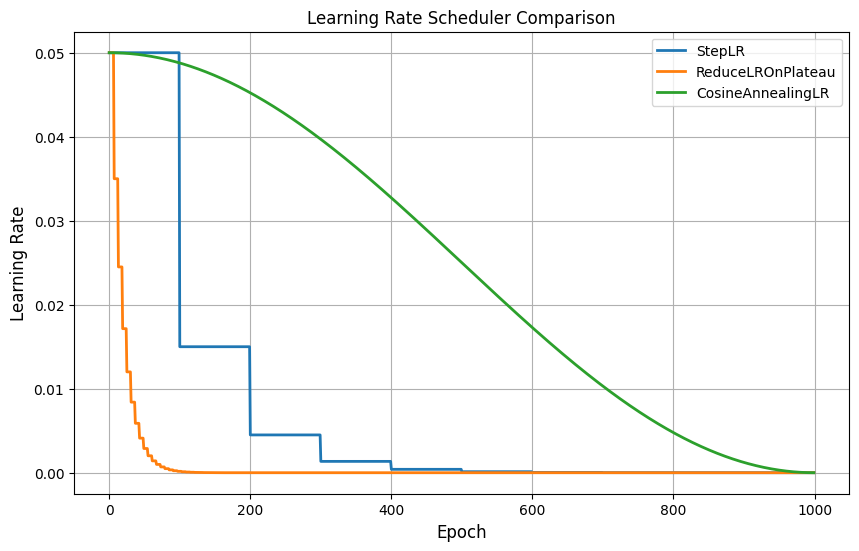

In [ ]:
X_train, X_test, y_train, y_test = prepare_data()

results = train_schedulers(X_train, X_test, y_train, y_test, lr=0.05, epochs=1000, hidden_dim=128)

def plot_lr_schedules(results):
    plt.figure(figsize=(10, 6))
    
    for name, result in results.items():
        plt.plot(result['simulated_lrs'], label=name, linewidth=2)
    
    plt.title('Learning Rate Scheduler Comparison')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Learning Rate', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_lr_schedules(results)